In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import LabelEncoder
from astroML.utils import split_samples, completeness_contamination
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [2]:
df_quasar = pd.read_csv("../../solutions/galaxyquasar.csv")
df_quasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
name = df_quasar['class'].copy()

In [4]:
u_g = np.array(df_quasar['u'] - df_quasar['g'])
g_r = np.array(df_quasar['g'] - df_quasar['r'])
r_i = np.array(df_quasar['r'] - df_quasar['i'])
i_z = np.array(df_quasar['i'] - df_quasar['z'])

In [5]:
le = LabelEncoder()
df_quasar['class'] = le.fit_transform(df_quasar['class'])
labels = le.inverse_transform(df_quasar['class'])
class_names = le.classes_
print(class_names)

['GALAXY' 'QSO']


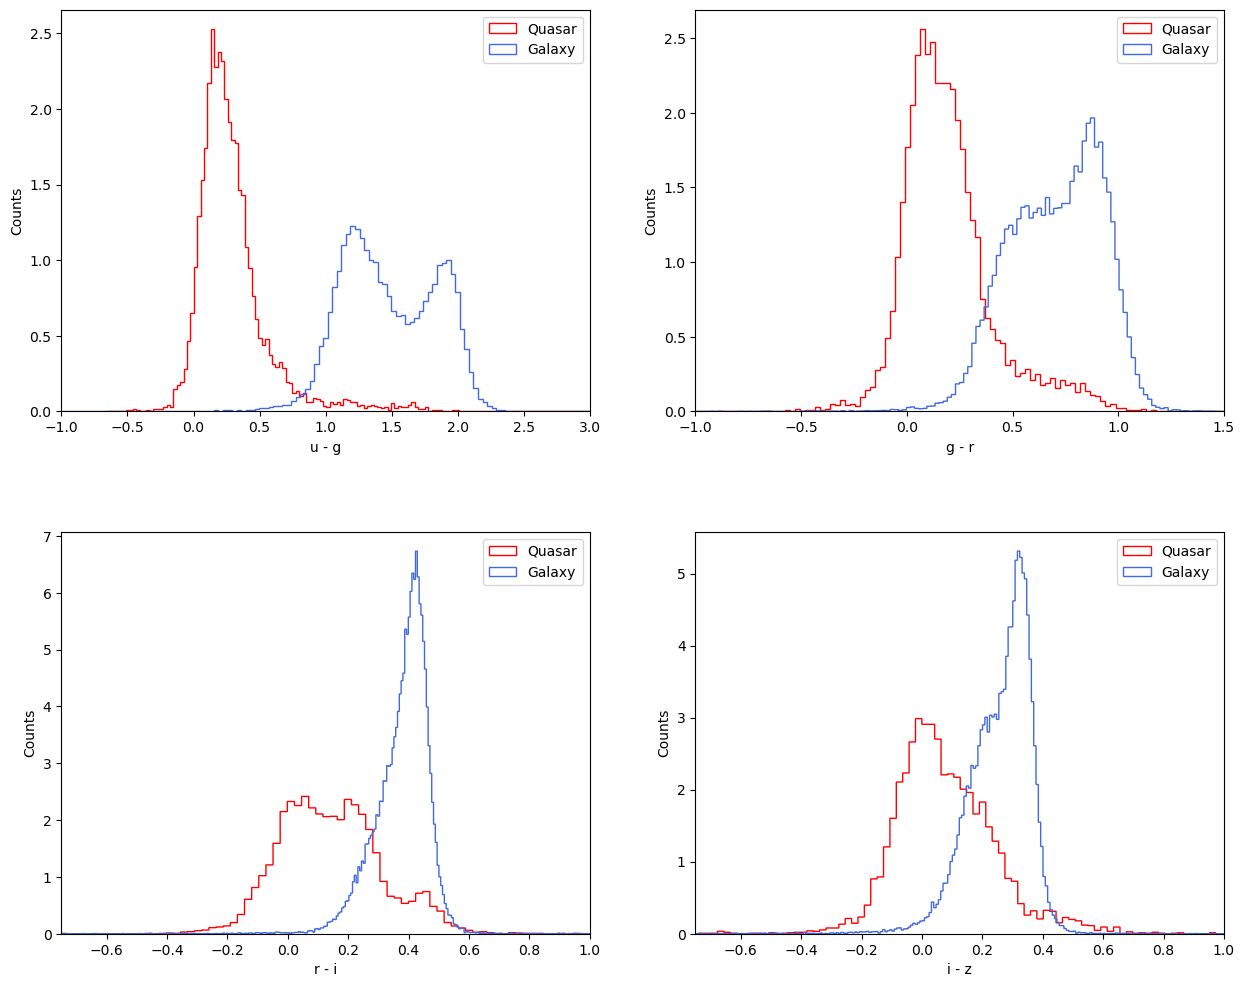

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

fancyhist(u_g[df_quasar['class']==1], bins="freedman", ax=axs[0,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(u_g[df_quasar['class']==0], bins="freedman", ax=axs[0,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

fancyhist(g_r[df_quasar['class']==1], bins="freedman", ax=axs[0,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(g_r[df_quasar['class']==0], bins="freedman", ax=axs[0,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_xlim(-1, 1.5)
axs[0,1].legend()

fancyhist(r_i[df_quasar['class']==1], bins="freedman", ax=axs[1,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(r_i[df_quasar['class']==0], bins="freedman", ax=axs[1,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlim(-0.75, 1)
axs[1,0].legend()

fancyhist(i_z[df_quasar['class']==1], bins="freedman", ax=axs[1,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(i_z[df_quasar['class']==0], bins="freedman", ax=axs[1,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_xlim(-0.75, 1)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

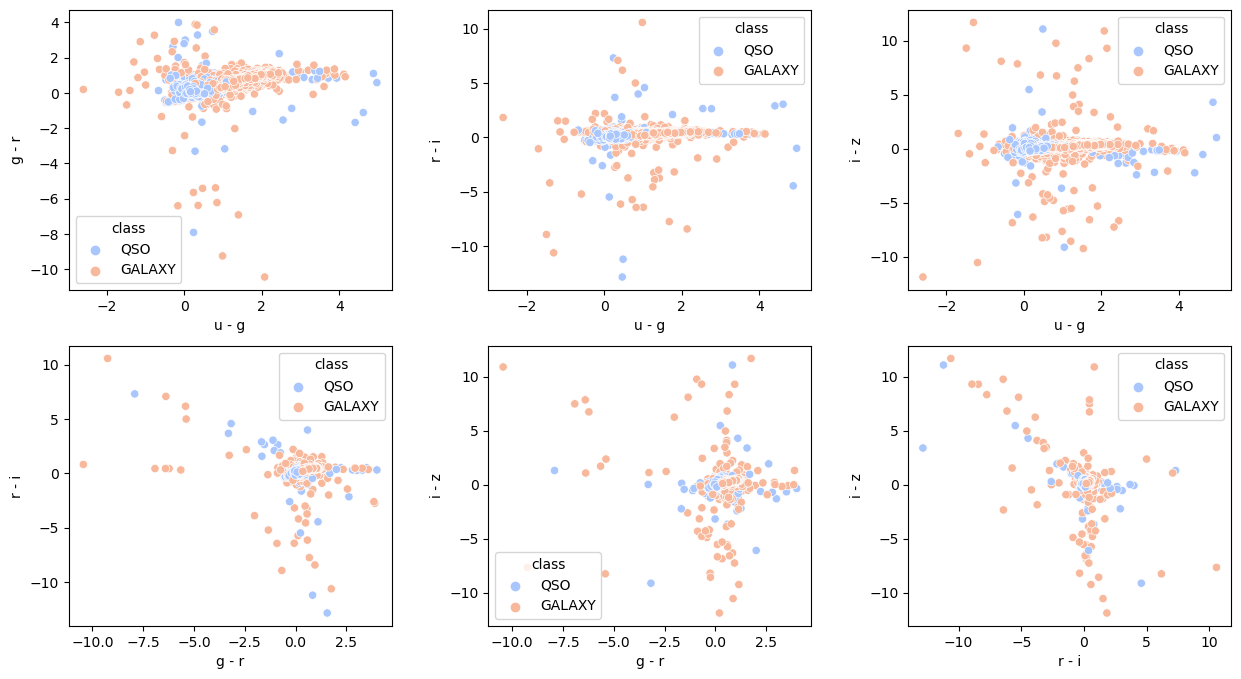

In [7]:
color = pd.DataFrame({'u - g': u_g, 'g - r': g_r, 'r - i': r_i, 'i - z': i_z})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

sns.scatterplot(data=color, x='u - g', y='g - r', hue=name, ax = axs[0,0], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='r - i', hue=name, ax = axs[0,1], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='i - z', hue=name, ax = axs[0,2], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='r - i', hue=name, ax = axs[1,0], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='i - z', hue=name, ax = axs[1,1], palette='coolwarm')
sns.scatterplot(data=color, x='r - i', y='i - z', hue=name, ax = axs[1,2], palette='coolwarm')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [8]:
def models(clf, X_train, X_test, y_train):
    names = []
    probs = []
    
    clf.fit(X_train, y_train)
    
    y_probs = clf.predict_proba(X_test)[:, 1]
    
    names.append(clf.__class__.__name__)
    probs.append(y_probs)

    return names, y_probs, probs

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              LogisticRegression='LR',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT')

In [58]:
def ROC (x, colors = 'All colors'):
    (X_train, X_test), (y_train, y_test) = split_samples(x, df_quasar['class'], [0.70, 0.30], random_state=42)

    classifiers = [GaussianNB(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               LogisticRegression(),
               KNeighborsClassifier(),
               DecisionTreeClassifier()]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for classifier in classifiers:
        name, y_prob, prob = models(classifier, X_train, X_test, y_train)
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)
        
        # add (0, 0) as first point
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
        # Here we add (1,0) 
        precision = np.concatenate([[0], precision])
        recall = np.concatenate([[1], recall])
        thresh2 = np.concatenate([[0], thresh2])   
        
        axs[0].plot(fpr, tpr, label=labels[name[0]])
        axs[1].plot(precision, recall, label=labels[name[0]])
    
    #axs[0].set_xlim(0, 0.2)
    axs[0].set_ylim(0, 1.02)
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend()
    
    axs[1].set_xlabel('Efficiency')
    axs[1].set_ylabel('Completeness')
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0.2, 1.02)

    if colors == 'All colors':
        plt.suptitle(colors, y=0.94)
    elif len(colors)==1:
        plt.suptitle('Color: %s' %(colors[0]), y=0.94)
    elif len(colors)==2:
        plt.suptitle('Colors: %s and %s' %(colors[0], colors[1]), y=0.94)
    elif len(colors)==3:
        plt.suptitle('Colors: %s, %s and %s' %(colors[0], colors[1], colors[2]), y=0.94)
    plt.show()       

def prediction(X_train, X_test, y_train):
    pred = []

    classifiers = [GaussianNB(),
               LinearDiscriminantAnalysis(),
               QuadraticDiscriminantAnalysis(),
               LogisticRegression(),
               KNeighborsClassifier(),
               DecisionTreeClassifier()]
    
    for clf in classifiers:
        clf.fit(X_train, y_train)
        pred.append(clf.predict(X_test))

    return pred, classifiers

## Subset of 1 colors

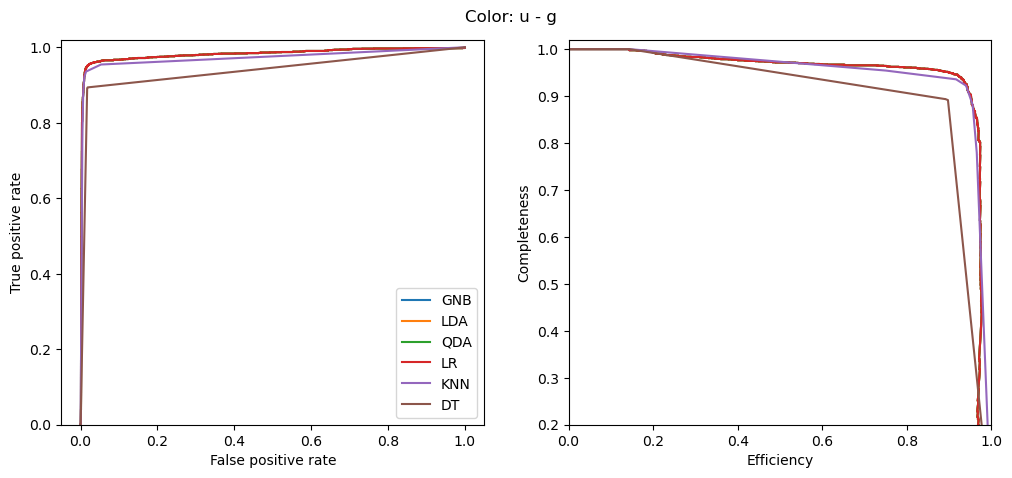

In [10]:
ROC(color.iloc[:, [0]], colors = [color.columns[0]])

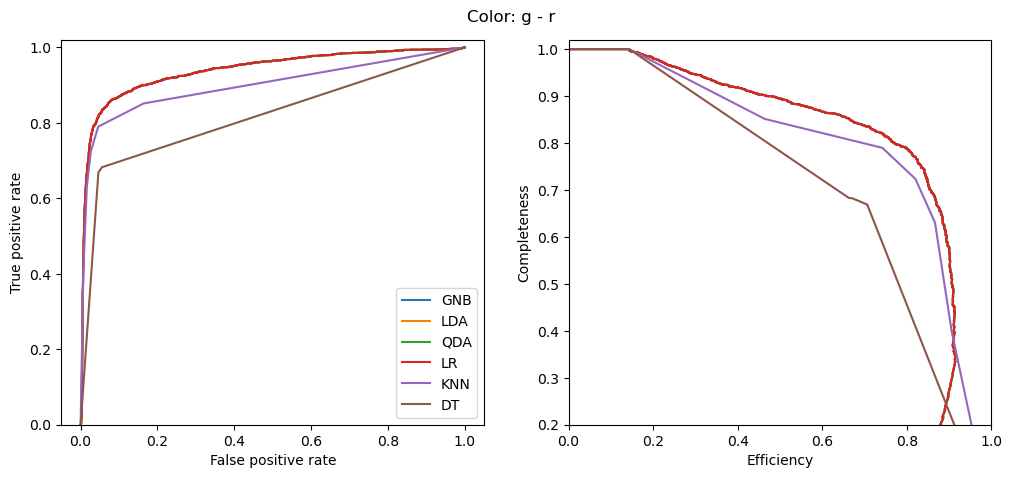

In [11]:
ROC(color.iloc[:, [1]], colors = [color.columns[1]])

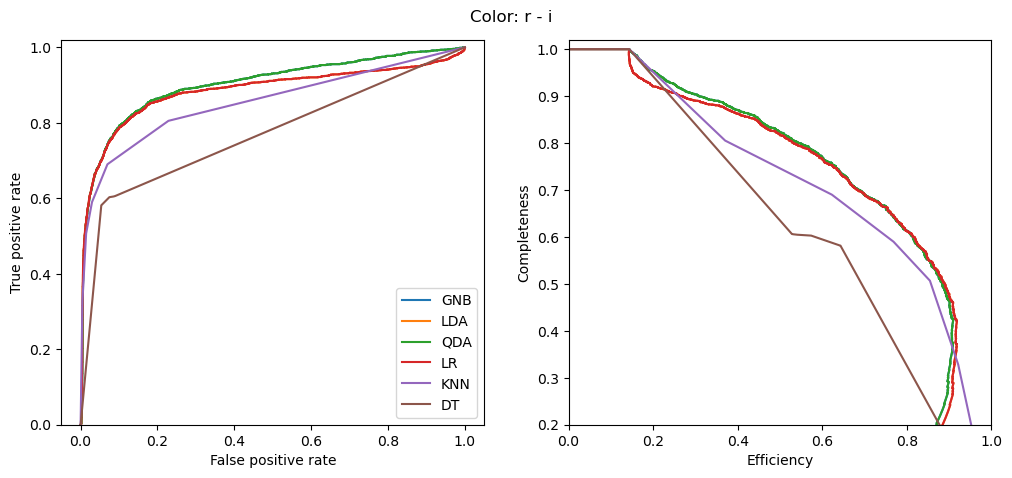

In [12]:
ROC(color.iloc[:, [2]], colors = [color.columns[2]])

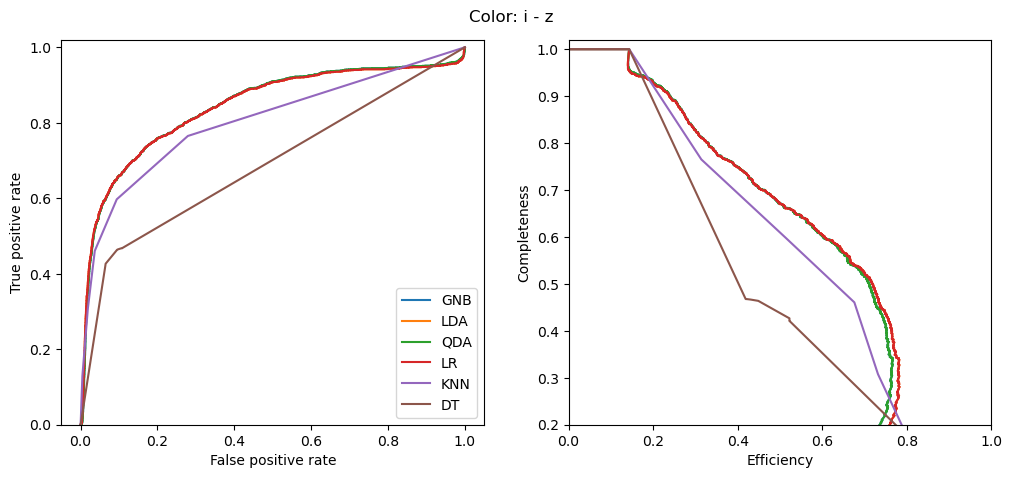

In [13]:
ROC(color.iloc[:, [3]], colors = [color.columns[3]])

## Subset of 2 colors

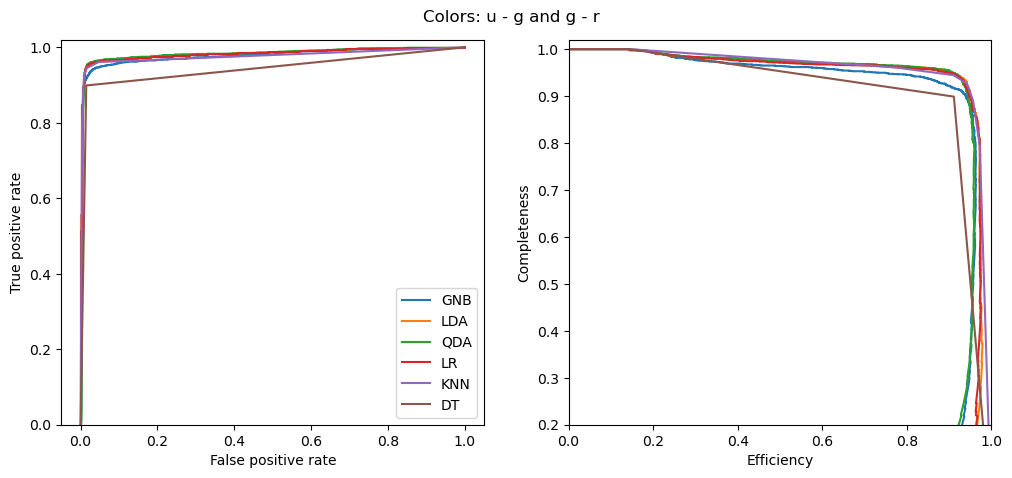

In [14]:
ROC(color.iloc[:, [0, 1]], colors = [color.columns[0], color.columns[1]])

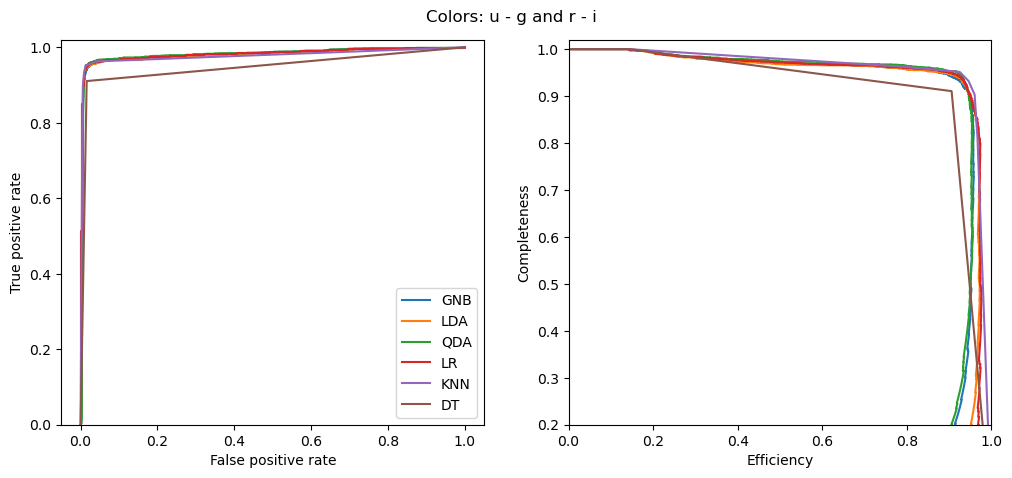

In [15]:
ROC(color.iloc[:, [0, 2]], colors = [color.columns[0], color.columns[2]])

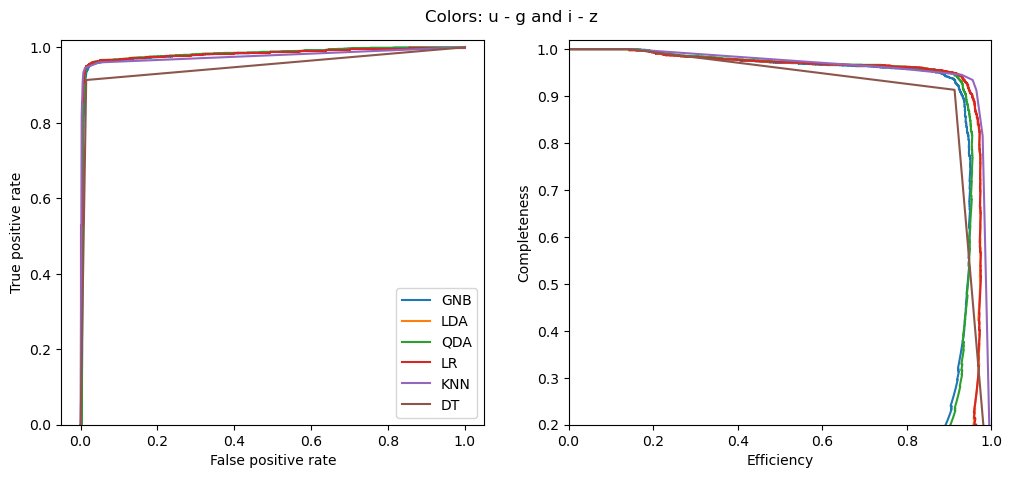

In [16]:
ROC(color.iloc[:, [0, 3]], colors = [color.columns[0], color.columns[3]])

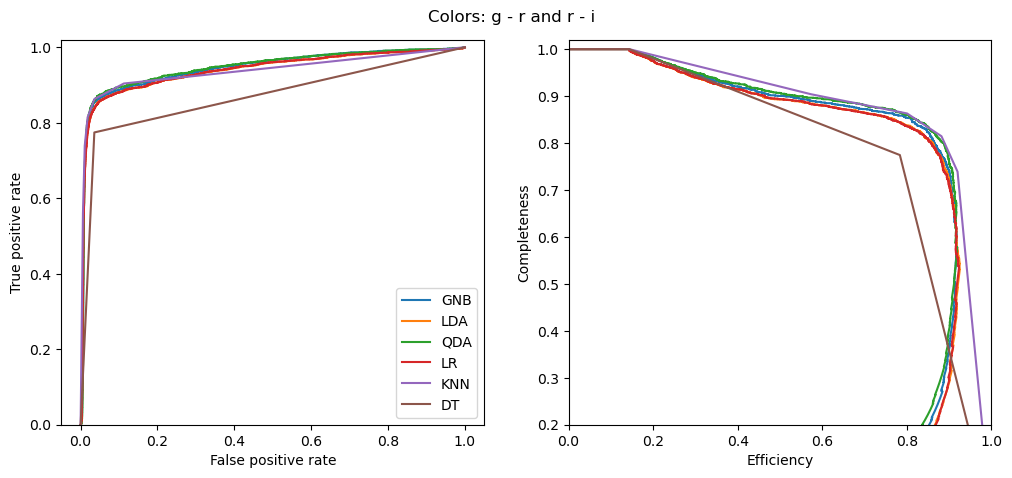

In [17]:
ROC(color.iloc[:, [1, 2]], colors = [color.columns[1], color.columns[2]])

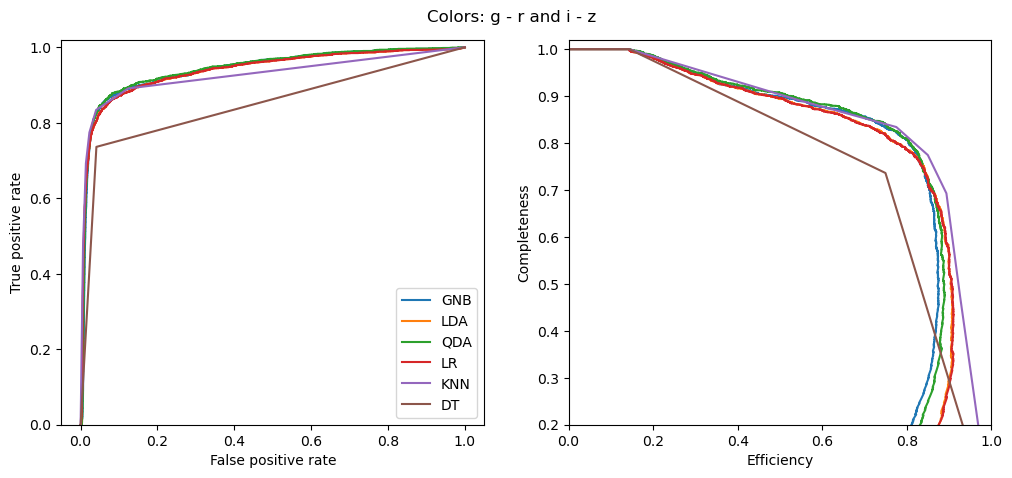

In [18]:
ROC(color.iloc[:, [1, 3]], colors = [color.columns[1], color.columns[3]])

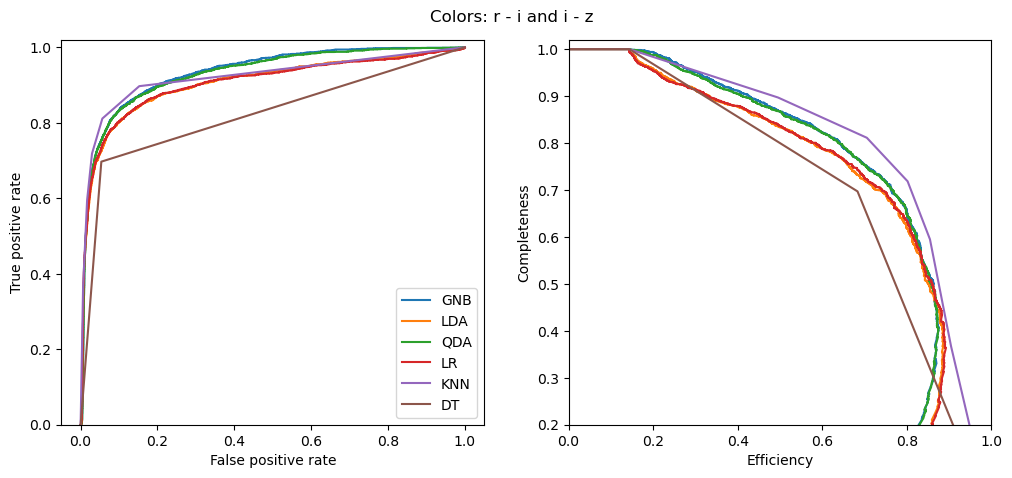

In [19]:
ROC(color.iloc[:, [2, 3]], colors = [color.columns[2], color.columns[3]])

## Subset of 3 colors

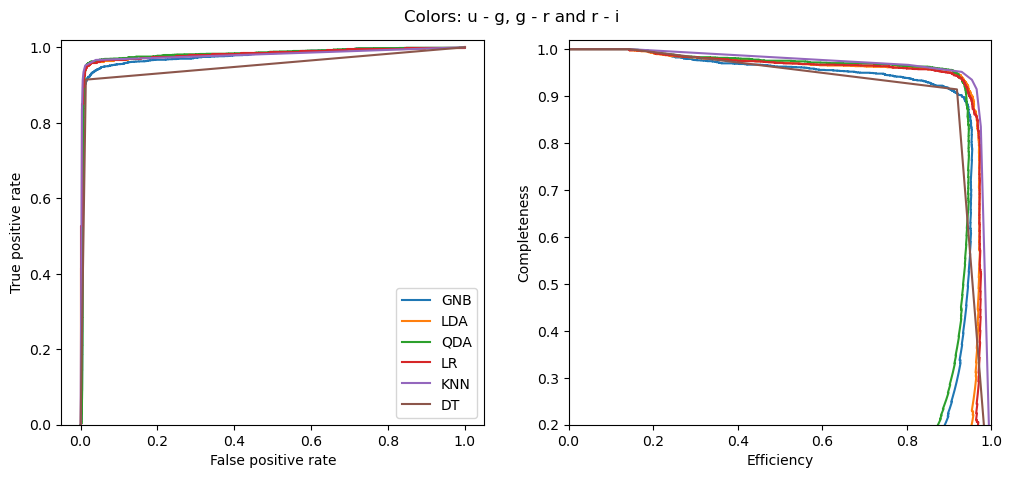

In [20]:
ROC(color.iloc[:, [0, 1, 2]], colors = [color.columns[0], color.columns[1], color.columns[2]])

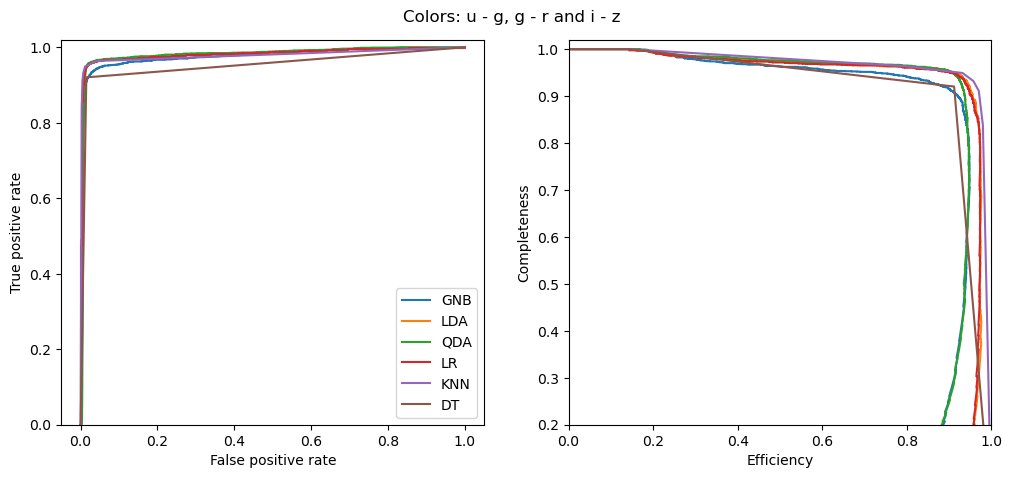

In [21]:
ROC(color.iloc[:, [0, 1, 3]], colors = [color.columns[0], color.columns[1], color.columns[3]])

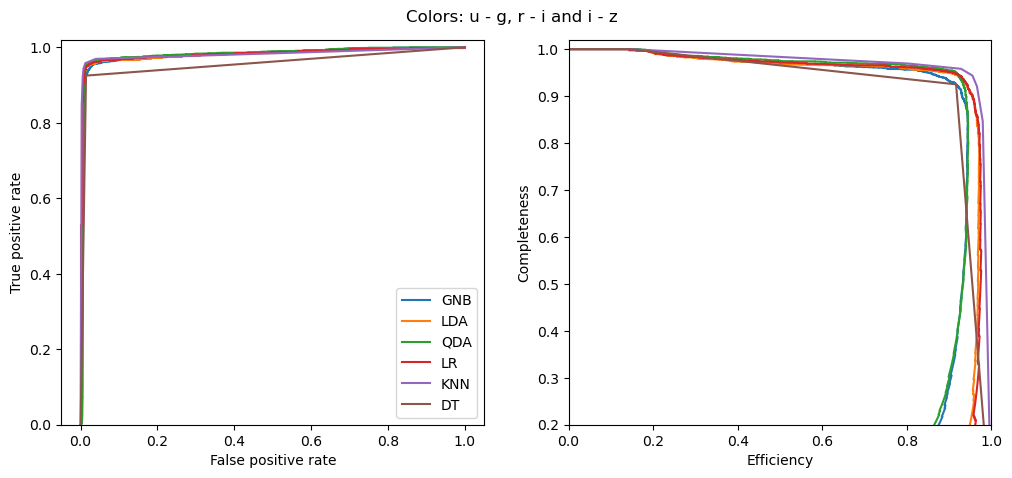

In [22]:
ROC(color.iloc[:, [0, 2, 3]], colors = [color.columns[0], color.columns[2], color.columns[3]])

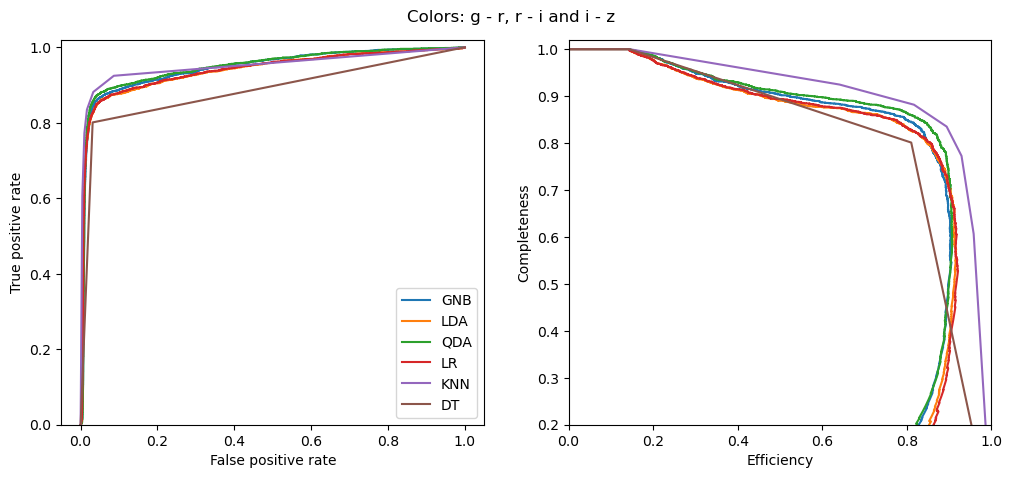

In [23]:
ROC(color.iloc[:, [1, 2, 3]], colors = [color.columns[1], color.columns[2], color.columns[3]])

## All colors

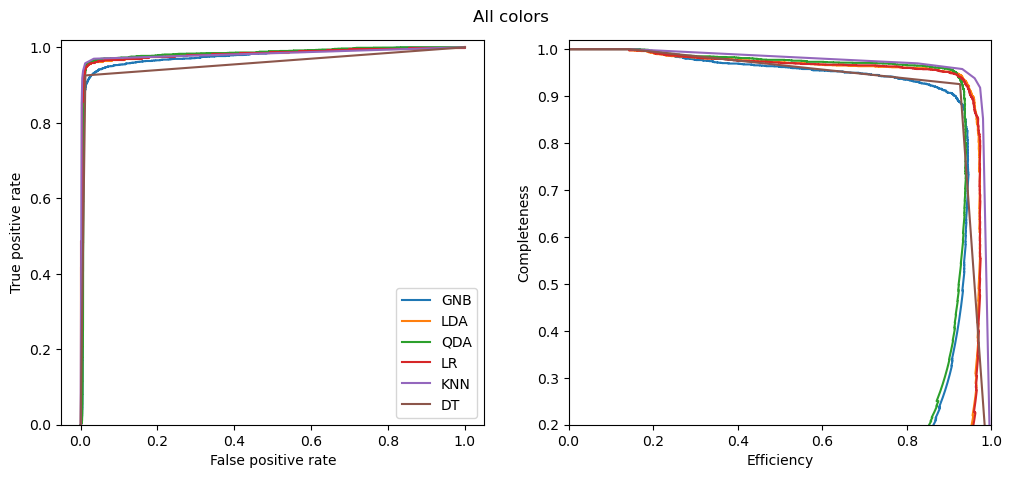

In [24]:
ROC(color)

## Predictions

#### 2 colors

In [70]:
(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [0,1]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, classifier = prediction(X_train, X_test, y_train)

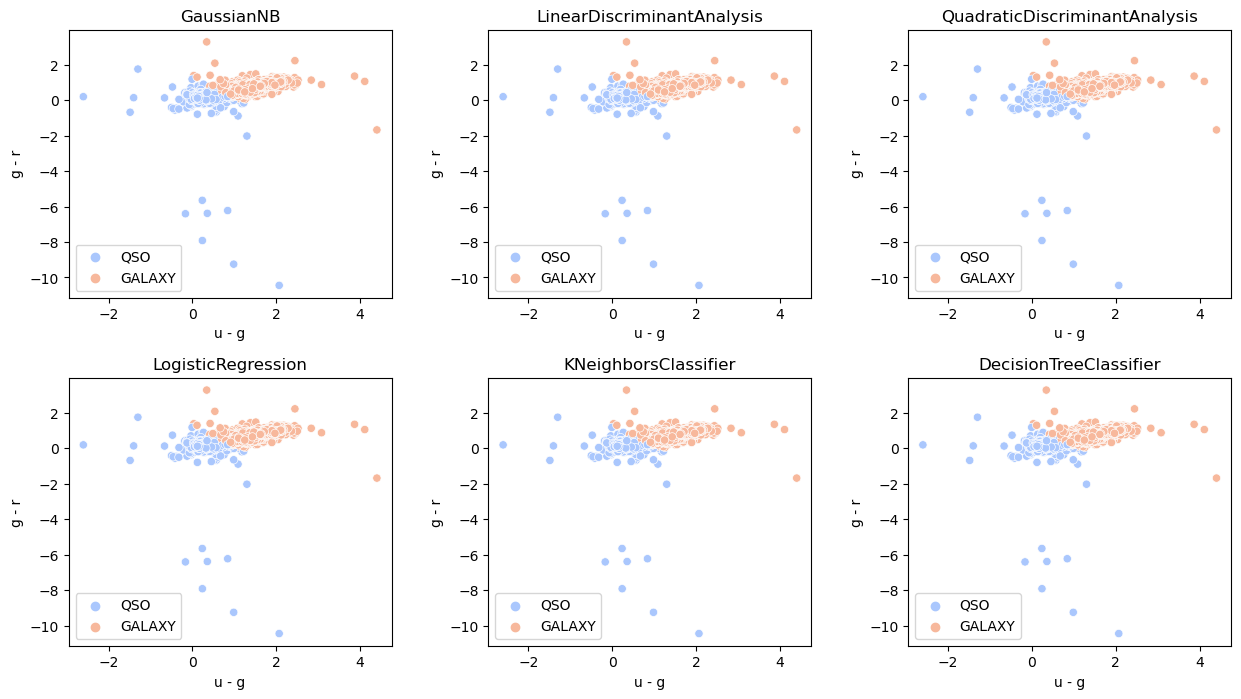

In [84]:
clrs = pd.DataFrame({'u - g': X_test[:, 0], 'g - r': X_test[:, 1]})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,0], hue=le.inverse_transform(pred[classifier==GaussianNB]), palette='coolwarm')
axs[0,0].set_title('GaussianNB')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,1], hue=le.inverse_transform(pred[classifier==LinearDiscriminantAnalysis]), palette='coolwarm')
axs[0,1].set_title('LinearDiscriminantAnalysis')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[0,2], hue=le.inverse_transform(pred[classifier==QuadraticDiscriminantAnalysis]), palette='coolwarm')
axs[0,2].set_title('QuadraticDiscriminantAnalysis')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,0], hue=le.inverse_transform(pred[classifier==LogisticRegression]), palette='coolwarm')
axs[1,0].set_title('LogisticRegression')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,1], hue=le.inverse_transform(pred[classifier==KNeighborsClassifier]), palette='coolwarm')
axs[1,1].set_title('KNeighborsClassifier')
sns.scatterplot(data=clrs, x='u - g', y='g - r', ax=axs[1,2], hue=le.inverse_transform(pred[classifier==DecisionTreeClassifier]), palette='coolwarm')
axs[1,2].set_title('DecisionTreeClassifier')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [94]:
print('Confusion matrix:\n')
for clf in classifier:
    print('%s:' %clf)
    print(confusion_matrix(y_test, pred[classifier==clf]),'\n')

Confusion matrix:

GaussianNB():
[[12590   265]
 [  157  1988]] 

LinearDiscriminantAnalysis():
[[12590   265]
 [  157  1988]] 

QuadraticDiscriminantAnalysis():
[[12590   265]
 [  157  1988]] 

LogisticRegression():
[[12590   265]
 [  157  1988]] 

KNeighborsClassifier():
[[12590   265]
 [  157  1988]] 

DecisionTreeClassifier():
[[12590   265]
 [  157  1988]] 



#### 1 color

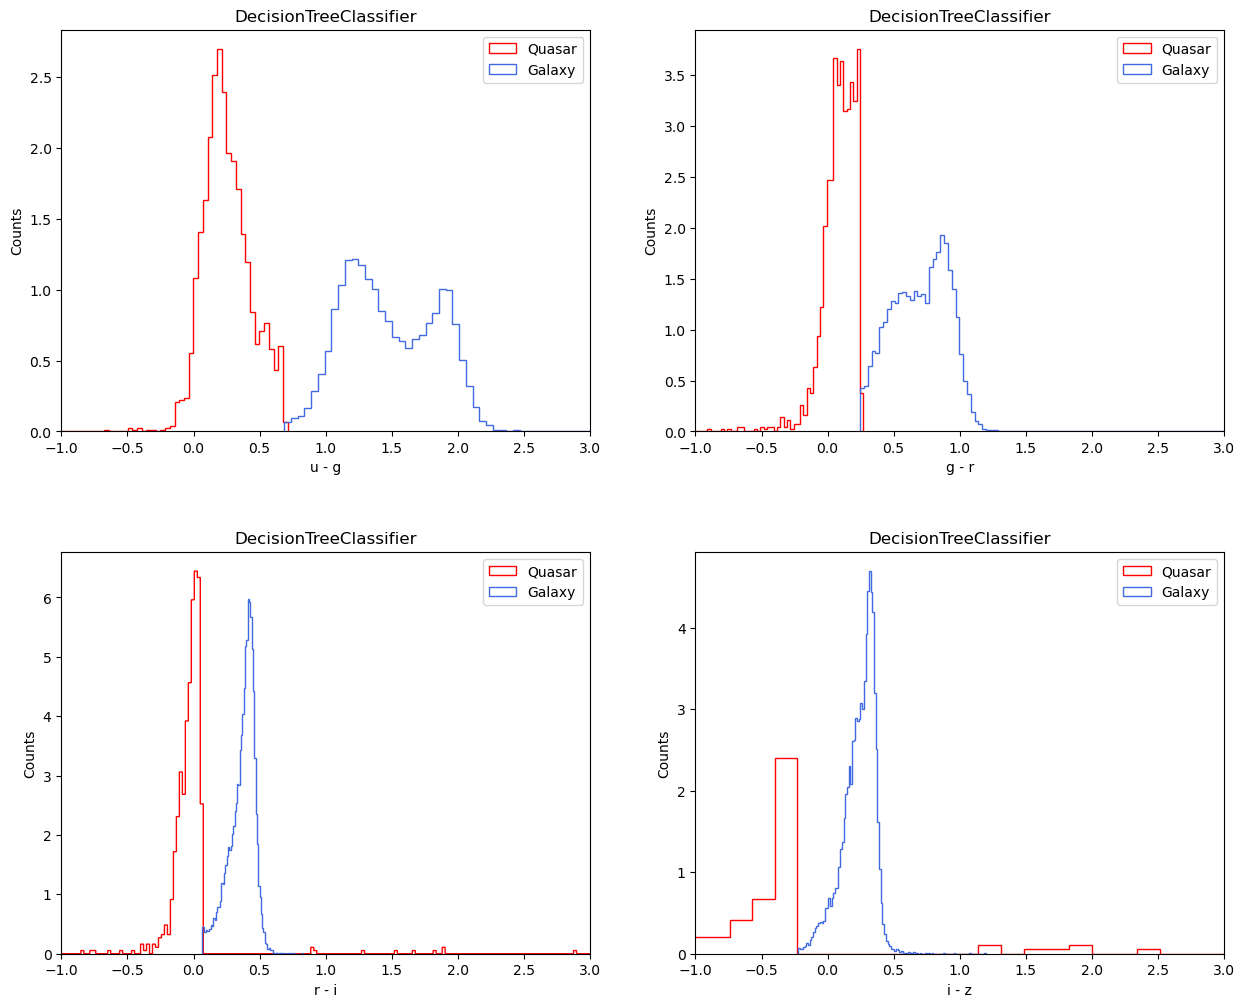

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [0]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, classifier = prediction(X_train, X_test, y_train)
c_1 = confusion_matrix(y_test, pred[classifier==DecisionTreeClassifier])
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==1, 0], bins="freedman", ax=axs[0,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==0, 0], bins="freedman", ax=axs[0,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('DecisionTreeClassifier')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [1]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, classifier = prediction(X_train, X_test, y_train)
c_2 = confusion_matrix(y_test, pred[classifier==DecisionTreeClassifier])
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==1, 0], bins="freedman", ax=axs[0,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==0, 0], bins="freedman", ax=axs[0,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('DecisionTreeClassifier')
axs[0,1].set_xlim(-1, 3)
axs[0,1].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [2]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, classifier = prediction(X_train, X_test, y_train)
c_3 = confusion_matrix(y_test, pred[classifier==DecisionTreeClassifier])
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==1, 0], bins="freedman", ax=axs[1,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==0, 0], bins="freedman", ax=axs[1,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('DecisionTreeClassifier')
axs[1,0].set_xlim(-1, 3)
axs[1,0].legend()

(X_train, X_test), (y_train, y_test) = split_samples(color.iloc[:, [3]], df_quasar['class'], [0.70, 0.30], random_state=42)
pred, classifier = prediction(X_train, X_test, y_train)
c_4 = confusion_matrix(y_test, pred[classifier==DecisionTreeClassifier])
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==1, 0], bins="freedman", ax=axs[1,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(X_test[pred[classifier==DecisionTreeClassifier]==0, 0], bins="freedman", ax=axs[1,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('DecisionTreeClassifier')
axs[1,1].set_xlim(-1, 3)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

In [106]:
C = [c_1, c_2, c_3, c_4]
print('Confusion matrix:\n')
for lab, c in zip(color.columns.tolist(), C):
    print('%s:' %lab)
    print(c,'\n')

Confusion matrix:

u - g:
[[12719   136]
 [  149  1996]] 

g - r:
[[12627   228]
 [  675  1470]] 

r - i:
[[12777    78]
 [ 1399   746]] 

i - z:
[[12786    69]
 [ 2102    43]] 

